Please see the colab version because this code doesn't work properly:

https://colab.research.google.com/drive/1fkAGqDvMw1MZwiUOWEmKVI3fdLLttAVY?usp=sharing

In [3]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# scraping data from understat
res = requests.get('https://understat.com/match/22787')

ConnectionError: HTTPSConnectionPool(host='understat.com', port=443): Max retries exceeded with url: /match/22787 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000221BE0E0F10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [ ]:
# parsing the content using BeautifulSoup
soup = BeautifulSoup(res.content, 'lxml')
scripts = soup.find_all('script')

In [ ]:
# extracting the content of the second <script> tag which contain necessary data
strings = scripts[1].string

In [ ]:
# strip unnecessary symbols and get only JSON data
ind_start = strings.index("('")+2
ind_end = strings.index("')")
json_data = strings[ind_start:ind_end]
json_data = json_data.encode('utf8').decode('unicode_escape')

# convert string to json format
data = json.loads(json_data)

In [ ]:
data

{'h': [{'id': '545508',
   'minute': '5',
   'result': 'Goal',
   'X': '0.9259999847412109',
   'Y': '0.5359999847412109',
   'xG': '0.548054039478302',
   'player': 'Ilkay Gündogan',
   'h_a': 'h',
   'player_id': '314',
   'situation': 'OpenPlay',
   'season': '2023',
   'shotType': 'RightFoot',
   'match_id': '22787',
   'h_team': 'Barcelona',
   'a_team': 'Real Madrid',
   'h_goals': '1',
   'a_goals': '2',
   'date': '2023-10-28 14:15:00',
   'player_assisted': None,
   'lastAction': 'None'},
  {'id': '545510',
   'minute': '15',
   'result': 'ShotOnPost',
   'X': '0.9069999694824219',
   'Y': '0.6309999847412109',
   'xG': '0.09907364845275879',
   'player': 'Fermín López',
   'h_a': 'h',
   'player_id': '11822',
   'situation': 'OpenPlay',
   'season': '2023',
   'shotType': 'RightFoot',
   'match_id': '22787',
   'h_team': 'Barcelona',
   'a_team': 'Real Madrid',
   'h_goals': '1',
   'a_goals': '2',
   'date': '2023-10-28 14:15:00',
   'player_assisted': 'Gavi',
   'lastAction

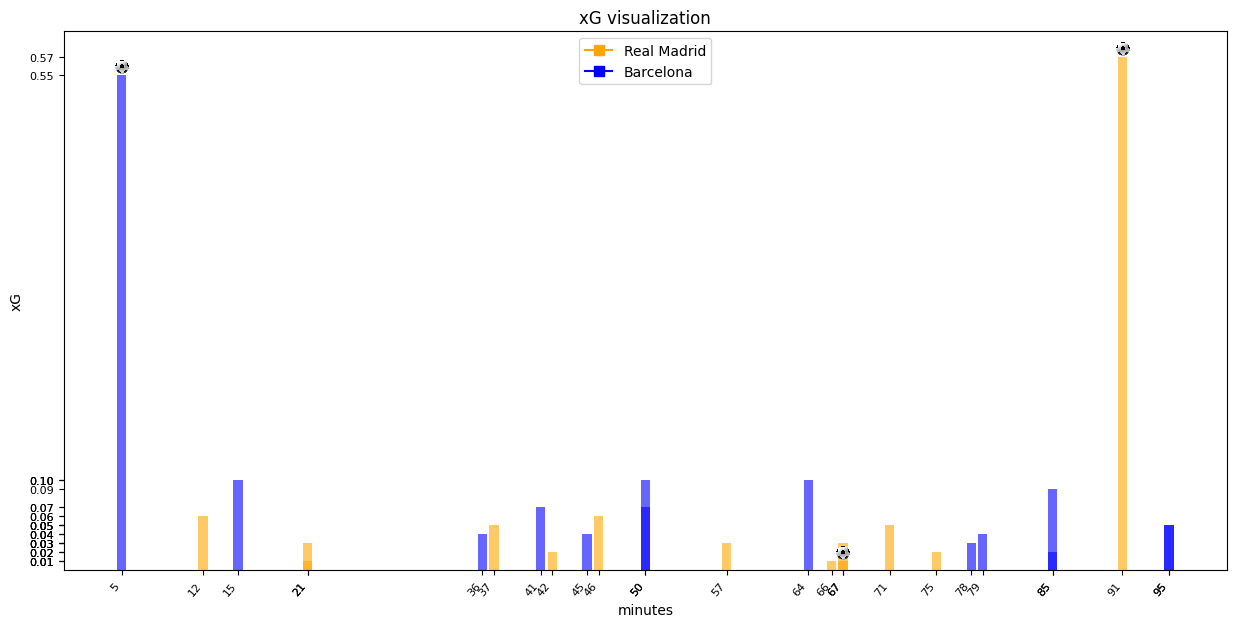

In [ ]:
import matplotlib.offsetbox as offsetbox
import matplotlib.lines as mlines
from PIL import Image

minute, xG, result, team, player = [], [], [], [], []
data_away = data['a']
data_home = data['h']

# extract relevant data from the match
for index in range(len(data_home)):
    for key in data_home[index]:
        if key == 'minute':
            minute.append(data_home[index][key])
        if key == 'result':
            result.append(data_home[index][key])
        if key == 'xG':
            xG.append(data_home[index][key])
        if key == 'player':
            player.append(data_home[index][key])
        if key == 'h_team':
            team.append(data_home[index][key])

for index in range(len(data_away)):
    for key in data_away[index]:
        if key == 'minute':
            minute.append(data_away[index][key])
        if key == 'result':
            result.append(data_away[index][key])
        if key == 'xG':
            xG.append(data_away[index][key])
        if key == 'player':
            player.append(data_away[index][key])
        if key == 'a_team':
            team.append(data_away[index][key])

# convert xG values to float and round them to 2 decimal places
xG = [str(round(float(num), 2)) for num in xG]

df = pd.DataFrame({
    'minute': minute,
    'xG': xG,
    'result': result,
    'player': player,
    'team': team
})


# convert 'xG' and 'minute' columns to numeric type for sorting
df['xG'] = pd.to_numeric(df['xG'])
df['minute'] = pd.to_numeric(df['minute'])
df = df.sort_values(by=['xG', 'minute'])

# create the plot
plt.figure(figsize=(15, 7))
bars = []
ball_url = "/content/ball.png"

# iterate over each row in the DataFrame and plot bars
for minute, xG, player, team, result in zip(df['minute'], df['xG'], df['player'], df['team'], df['result']):
    # determine the color of the bar based on the team
    if 'Real Madrid' in team:
        color = 'orange'
    else:
        color = 'blue'
    # set transparency to see both teams' columns when they are in the same position
    bar = plt.bar(minute, xG, color=color, alpha=0.6)
    bars.append(bar[0])
    # if it's a goal - add a football icon above the bar
    if result == 'Goal':
        ball_img = Image.open(ball_url)
        img_offset = offsetbox.OffsetImage(ball_img, zoom=0.02)
        ab = offsetbox.AnnotationBbox(img_offset, (minute, xG + 0.009), frameon=False)
        plt.gca().add_artist(ab)


# adding labels and title
plt.xlabel('minutes')
plt.ylabel('xG')
plt.title('xG visualization')

# customize ticks
plt.xticks(df['minute'], rotation=50, ha='right', fontsize=8)
plt.yticks(df['xG'], fontsize=8)

# each handle represents a team with a specific color and marker style
legend_handles = [
    mlines.Line2D([], [], color='orange', marker='s', markersize=7, label='Real Madrid'),
    mlines.Line2D([], [], color='blue', marker='s', markersize=7, label='Barcelona'),
]
plt.legend(handles=legend_handles, loc='upper center')

# show the plot
plt.show()